In [1]:
import pandas as pd
from googleapiclient.discovery import build

In [ ]:
API_KEY = 'YOUR_API_KEY'

In [3]:
def getTrendingVideos(api_key, maxResult = 200):
    youtube = build('youtube', 'v3', developerKey=api_key)

    videos = []

    request = youtube.videos().list(
        part = 'snippet,contentDetails,statistics',
        chart = 'mostPopular',
        regionCode = 'US',
        maxResults = 50
    )

    while request and len(videos) < maxResult:
        response = request.execute()
        for item in response['items']:
            videoDetails = {
                'videoId' : item['id'],
                'title' : item['snippet']['title'],
                'description' : item['snippet']['description'],
                'publishedAt' : item['snippet']['publishedAt'],
                'channelId' : item['snippet']['channelId'],
                'categoryId' : item['snippet']['categoryId'],
                'tags' : item['snippet'].get('tags', []),
                'duration' : item['contentDetails']['duration'],
                'definition' : item['contentDetails']['definition'],
                'caption' : item['contentDetails']['caption'],
                'likeCount' : item['statistics'].get('likeCount', 0),
                'viewCount' : item['statistics'].get('viewCount', 0),
                'commentCount' : item['statistics'].get('commentCount', 0),
                'dislikeCount' : item['statistics'].get('dislikeCount', 0),
                'favoriteCount' : item['statistics'].get('favoriteCount', 0)
            }
            videos.append(videoDetails)
        request = youtube.videos().list_next(request, response)
    return videos[:maxResult]




            


In [4]:
def saveToCSV(data, filename):
    dataInCSV = pd.DataFrame(data)
    dataInCSV.to_csv(filename, index=False)

In [ ]:
def main():
    trendingVideos = getTrendingVideos(API_KEY, maxResult=200)
    fileName = 'trendingVideosData.csv'
    saveToCSV(trendingVideos, fileName)
    print(f'Data of trending videos saved to {fileName}')

if __name__ == '__main__':
    main()

In [ ]:
trendingVideos = pd.read_csv('trendingVideosData.csv')
print(trendingVideos.head())

In [ ]:
missingValues = trendingVideos.isnull().sum()
dataTypes = trendingVideos.dtypes

dataTypes, missingValues

In [ ]:
trendingVideos['viewCount'].fillna(0, inplace=True)

In [9]:
trendingVideos['publishedAt'] = pd.to_datetime(trendingVideos['publishedAt'])

In [10]:
trendingVideos['tags'] = trendingVideos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [ ]:
descriptive_stats = trendingVideos[['viewCount', 'likeCount', 'dislikeCount', 'commentCount']].describe()

descriptive_stats

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

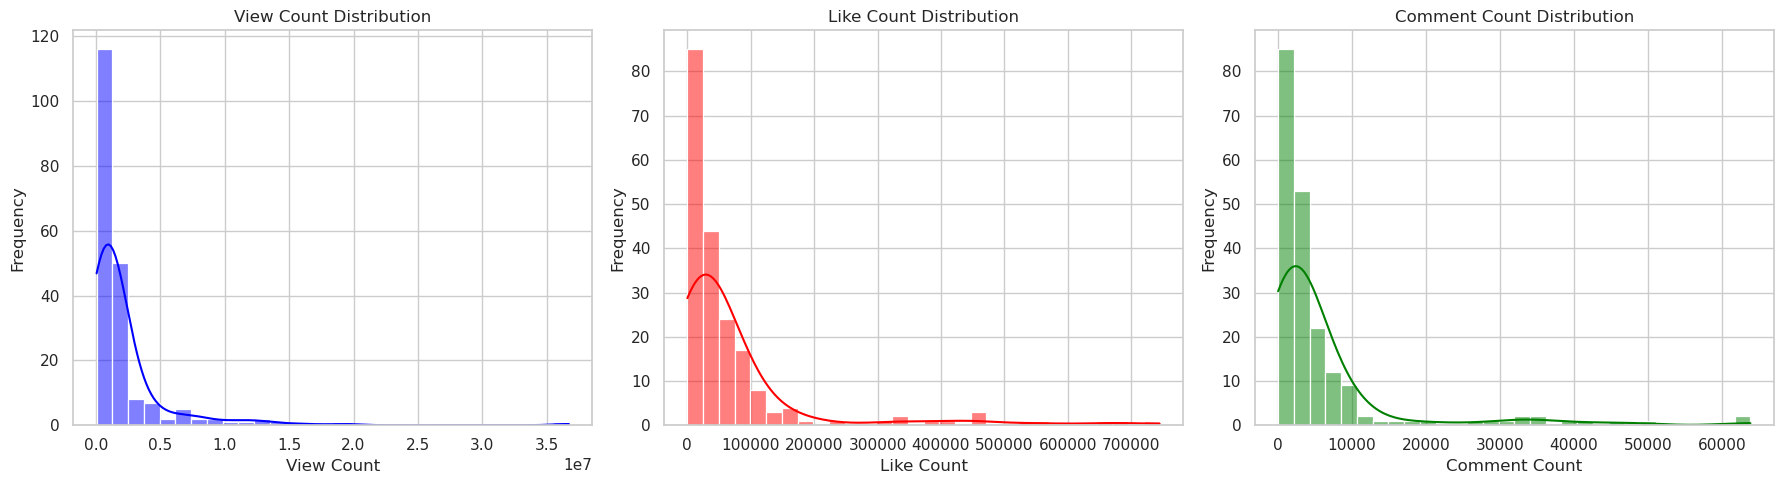

In [13]:
fig, axes = plt.subplots(1, 3, figsize = (18, 5))

sns.histplot(trendingVideos['viewCount'], bins = 30, kde = True, ax = axes[0], color = 'blue')
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

sns.histplot(trendingVideos['likeCount'], bins = 30, kde = True, ax = axes[1], color = 'red')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

sns.histplot(trendingVideos['commentCount'], bins = 30, kde = True, ax = axes[2], color = 'green')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

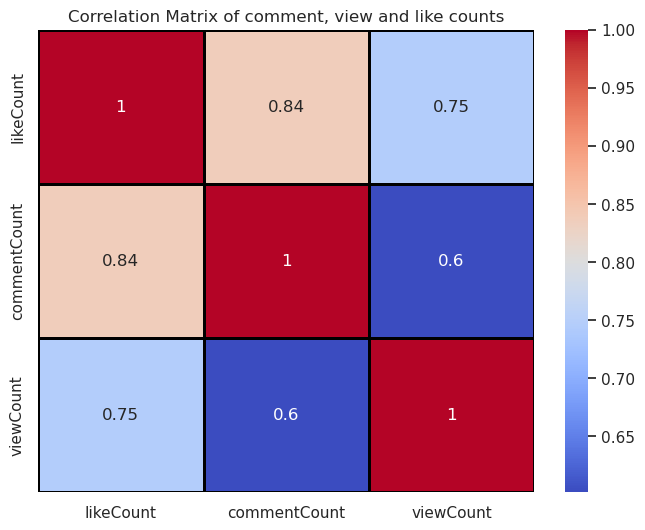

In [14]:
correlationMatrix = trendingVideos[['likeCount', 'commentCount', 'viewCount']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', linewidths='1.0', linecolor='black')
plt.title('Correlation Matrix of comment, view and like counts')
plt.show()

In [ ]:
from googleapiclient.discovery import build

youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

category_mapping = get_category_mapping()
print(category_mapping)

In [ ]:
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

plt.figure(figsize=(12, 8))
sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, palette='viridis')
plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

In [ ]:

category_engagement = trending_videos.groupby('category_name')[['view_count', 'like_count', 'comment_count']].mean().sort_values(by='view_count', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))


sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], palette='viridis')
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis')
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='viridis')
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
!pip install isodate
import isodate

trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos['duration_range'] = pd.cut(trending_videos['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos, alpha=0.6, color='purple')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

length_engagement = trending_videos.groupby('duration_range')[['view_count', 'like_count', 'comment_count']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 8))


sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')


sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma')
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')


sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma')
axes[2].set_title('Average Comment Count by Duration Range')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()